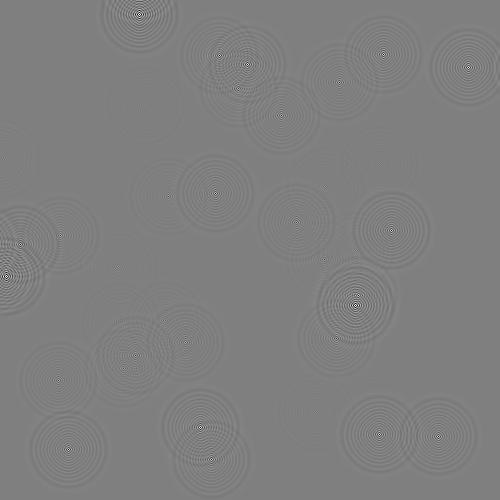

In [2]:
#시뮬레이션을 위한 라이브러리 임포트
import tensorflow as tf
import numpy as np

#보여주기위한 임포트
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display


def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  """Display an array as a picture."""
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  clear_output(wait = True)
  display(Image(data=f.getvalue()))

sess = tf.InteractiveSession()

def make_kernel(a):
  """2차 배열을 콘볼루션 커널로 변환"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """간단한 2차 콘볼루션 연산"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def laplace(x):
  """2차 배열의 라플라시안 계산"""
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv(x, laplace_k)


N = 500
# 조건 초기화 -- 몇개의 빗방울이 연못에 떨어뜨립니다

# 전부 0으로 설정
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

# 몇개의 빗방울이 연못의 임의 위치에 떨어뜨립니다
for n in range(40):
  a,b = np.random.randint(0, N, 2)
  u_init[a,b] = np.random.uniform()

DisplayArray(u_init, rng=[-0.1, 0.1])


# 매개변수:
# eps -- 시간 해상도
# damping -- 파고감쇠
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# 시뮬레이션 상태를 위한 변수 생성
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# 이산화된 PDE 갱신 규칙
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# 상태 갱신 명령
step = tf.group(
  U.assign(U_),
  Ut.assign(Ut_))

# 초기 조건에 대한 상태 초기화
tf.global_variables_initializer().run()

# 1000 번의 PDE 수행
for i in range(1000):
  # 단계 시뮬레이션
  step.run({eps: 0.03, damping: 0.04})
  DisplayArray(U.eval(), rng=[-0.1, 0.1])
